In [1]:
!pip install -U langchain-groq langchain tavily-python replicate langgraph matplotlib -q
!pip install langgraph-checkpoint-sqlite langchain_community -q

In [2]:
from google.colab import userdata
GROQ_API_KEY=userdata.get('groq_api_key')
TAVILY_API_KEY=userdata.get('TAVILY_API_KEY')

In [3]:
import os
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [4]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults
from datetime import datetime
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

# LLM chain
llm = ChatGroq(temperature=0, model="llama3-8b-8192",api_key=GROQ_API_KEY)

In [5]:
system = "You are a helpful assistant."
human = "{text}"
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

chain = prompt | llm
chain.invoke({"text": "How can i decrease the latency in LLMs."})

AIMessage(content="Latency in Large Language Models (LLMs) can be a significant issue, especially when it comes to real-time applications or high-stakes decision-making. Here are some strategies to help decrease latency in LLMs:\n\n1. **Optimize Model Architecture**: Designing a more efficient model architecture can significantly reduce latency. Consider using:\n\t* Smaller models with fewer parameters\n\t* Depth-wise separable convolutions\n\t* Attention mechanisms with reduced complexity\n2. **Pruning and Quantization**: Remove redundant or less important weights and quantize the model to reduce the number of calculations:\n\t* Prune weights to reduce the number of parameters\n\t* Quantize weights to reduce precision (e.g., from 32-bit to 8-bit)\n3. **Model Compression**: Compress the model using techniques like:\n\t* Knowledge Distillation: Train a smaller model to mimic the behavior of a larger one\n\t* Model pruning and knowledge distillation\n\t* Model compression using technique

In [6]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

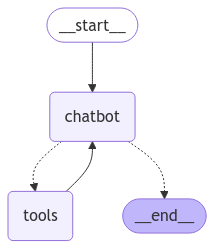

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hi
Assistant: 
Assistant: [{"url": "https://dictionary.cambridge.org/dictionary/english/hi", "content": "HI | English meaning - Cambridge Dictionary Meaning of hi in English hi Hi, there! Hi, how are you doing? HI (Definition of hi from the Cambridge Advanced Learner's Dictionary & Thesaurus © Cambridge University Press) hi | American Dictionary hi Hi, how are you doing? (Definition of hi from the Cambridge Academic Content Dictionary © Cambridge University Press) What is the pronunciation of hi? Translations of hi hi More meanings of hi Free word lists and quizzes from Cambridge Word lists shared by our community of dictionary fans English–Arabic English–Bengali English–Catalan English–Czech English–Danish English–Gujarati English–Hindi English–Korean English–Malay English–Marathi English–Russian English–Tamil English–Telugu English–Thai English–Turkish English–Ukrainian English–Urdu English–Vietnamese To add hi to a word list please sign up or log in."}, {"url": "https://usdict